# Basic example

FaIR v2.1 is object-oriented and designed to be more flexible than its predecessors. This does mean that setting up a problem is different to before - gone are the days of 60 keyword arguments to `fair_scm` and we now use classes and functions with fewer arguments that in the long run should be easier to use. Of course, there is a learning curve, and will take some getting used to. This tutorial aims to walk through a simple problem using FaIR 2.1.

The structure of FaIR 2.1 centres around the `FAIR` class, which contains all information about the scenario(s), the forcer(s) we want to investigate, and any configurations specific to each species and the response of the climate.

## Note

The code in this introductory block is explanatory and if you try to copy and paste it it you'll get errors. The code in this file is self-contained below the heading "1. Create FaIR instance" below. Alternatively, check out the repository from GitHub and run this example notebook in `jupyter`. Details [here](https://docs.fairmodel.net/en/latest/install.html).

## Some basics

A run is initialised as follows:

```
f = FAIR()
```

To this we need to add some information about the time horizon of our model, forcers we want to run with, their configuration (and the configuration of the climate), and optionally some model control options:

```
f.define_time(2000, 2050, 1)
f.define_scenarios(['abrupt', 'ramp'])
f.define_configs(['high', 'central', 'low'])
f.define_species(species, properties)
f.ghg_method='Myhre1998'
```

We generate some variables: emissions, concentrations, forcing, temperature etc.:
```
f.allocate()
```

which creates `xarray` DataArrays that we can fill in:
```
fill(f.emissions, 40, scenario='abrupt', specie='CO2 FFI')
...
```

Finally, the model is run with

```
f.run()
```

Results are stored within the `FAIR` instance as `xarray` DataArrays or Dataset, and can be obtained such as

```
print(fair.temperature)
```

Multiple `scenarios` and `configs` can be supplied in a `FAIR` instance, and due to internal parallelisation is the fastest way to run the model (100 ensemble members per second for 1750-2100 on my Mac for an emissions driven run). The total number of scenarios that will be run is the product of `scenarios` and `configs`. For example we might want to run three emissions `scenarios` -- let's say SSP1-2.6, SSP2-4.5 and SSP3-7.0 -- using climate calibrations (`configs`) from the UKESM, GFDL, MIROC and NorESM climate models. This would give us a total of 12 ensemble members in total which are run in parallel.

The most difficult part to learning FaIR 2.1 is correctly defining the `scenarios` and `configs`. As in previous versions of FaIR, there is a lot of flexibility, and simplifying the calling interface (`fair_scm` in v1.x) has come at the cost of switching this around to the `FAIR` class, and things have to be defined in the right order usually.

## Recommended order for setting up a problem

In this tutorial the recommended order in which to define a problem is set out step by step, and is as follows:

1. Create the `FAIR` instance, inititalised with run control options.
2. Define the time horizon of the problem with `FAIR.define_time()`
3. Define the scenarios to be run (e.g. SSPs, IAM emissions scenarios, or anything you want) with `FAIR.define_scenarios()`.
4. Define the configurations to be run with `FAIR.define_configs()`. A configuration (`config`) is a set of parameters that describe climate response and species response parameters. For example you might have a `config` with high climate sensitivity and strong aerosol forcing, and one with low climate sensitivity and weak aerosol forcing.
5. Define which `specie`s will be included in the problem, and their properties including the run mode (e.g. emissions-driven, concentration driven) with `FAIR.define_species()`.
6. Optionally, modify run control options.
7. Create input and output `DataArrays` with `FAIR.allocate()`.
8. Fill in the DataArrays (e.g. emissions), climate configs, and species configs, by either working directly with the `xarray` API, or using FaIR-packaged convenience functions like `fill` and `initialise`.
9. Run: `FAIR.run()`.
10. Analyse results by accessing the DataArrays that are attributes of `FAIR`.

# Credit

https://github.com/OMS-NetZero/FAIR

Dr. Chris Smith, University of Leeds

### 1. Create FaIR instance

We'll call our instance `f`: it's nice and short and the `fair` name is reserved for the module.

In [1]:
from fair import FAIR

In [2]:
f = FAIR()

### 2. Define time horizon

There are two different time indicators in FaIR: the `timebound` and the `timepoint`. `timebound`s, as the name suggests, are at the edges of each time step; they can be thought of as instantaneous snapshots. `timepoint`s are what happens between time bounds and are rates or integral quantities. 

The main thing to remember is that only `emissions` are defined on `timepoint`s and everything else is defined on `timebound`s, and when we specify the time horizon in our model, we are defining the `timebound`s of the problem.

Secondly, the number of `timebound`s is one more than the number of `timepoint`s, as the start and end points are included in the `timebound`s.

In [3]:
# create time horizon with bounds of 2000 and 2050, at 1-year intervals
f.define_time(2000, 2050, 1)
print(f.timebounds)
print(f.timepoints)

[2000. 2001. 2002. 2003. 2004. 2005. 2006. 2007. 2008. 2009. 2010. 2011.
 2012. 2013. 2014. 2015. 2016. 2017. 2018. 2019. 2020. 2021. 2022. 2023.
 2024. 2025. 2026. 2027. 2028. 2029. 2030. 2031. 2032. 2033. 2034. 2035.
 2036. 2037. 2038. 2039. 2040. 2041. 2042. 2043. 2044. 2045. 2046. 2047.
 2048. 2049. 2050.]
[2000.5 2001.5 2002.5 2003.5 2004.5 2005.5 2006.5 2007.5 2008.5 2009.5
 2010.5 2011.5 2012.5 2013.5 2014.5 2015.5 2016.5 2017.5 2018.5 2019.5
 2020.5 2021.5 2022.5 2023.5 2024.5 2025.5 2026.5 2027.5 2028.5 2029.5
 2030.5 2031.5 2032.5 2033.5 2034.5 2035.5 2036.5 2037.5 2038.5 2039.5
 2040.5 2041.5 2042.5 2043.5 2044.5 2045.5 2046.5 2047.5 2048.5 2049.5]


### 3. Define scenarios

The scenarios are a list of strings that label the scenario dimension of the model, helping you keep track of inputs and outputs.

In this example problem we will create two scenarios: an "abrupt" scenario (where emissions or concentrations change instantly) and a "ramp" scenario where they change gradually.

In [4]:
# Define two scenarios
f.define_scenarios(["abrupt", "ramp"])
f.scenarios

['abrupt', 'ramp']

### 4. Define configs

Similarly to the scenarios, the configs are a labelling tool. Each config has associated climate- and species-related settings, which we will come to later. 

We'll use three config sets, crudely corresponding to high, medium and low climate sensitivity.

In [5]:
# Define three scenarios
f.define_configs(["high", "central", "low"])
f.configs

['high', 'central', 'low']

### 5. Define species

This defines the forcers -- anthropogenic or natural -- that are present in your scenario. A `species` could be something directly emitted like CO2 from fossil fuels, or it could be a category where forcing has to be calculate from precursor emissions like aerosol-cloud interactions.

Each `specie` is assigned a name that is used to distinguish it from other species. You can call the species what you like within the model as long as you are consistent. We also pass a dictionary of `properties` that defines how each specie behaves in the model.

In this example we'll start off running a scenario with CO2 from fossil fuels and industry, CO2 from AFOLU, CH4, N2O, and Sulfur (note you don't need the full 40 species used in v1.1-1.6, and some additional default ones are included). From these inputs we also want to determine forcing from aerosol-radiation and aerosol-cloud interactions, as well as CO2, CH4 and N2O.

To highlight some of the functionality we'll run CO2 and Sulfur emissions-driven, and CH4 and N2O concentration-driven. (This is akin to an `esm-ssp585` kind of run from CMIP6, though with fewer species). We'll use totally fake data here - this is not intended to represent a real-world scenario but just to highlight how FaIR works. Full simulations may have 50 or more species included and the `properties` dictionary can get quite large, so it can be beneficial to edit it in a CSV and load it in.

In total, we have 8 species in this model. We want to run

1. CO2 fossil and industry
2. CO2 AFOLU
3. Sulfur

with specified emissions. 

We want to run

4. CH4
5. N2O

with specified concentrations. We also want to calculate forcing from CO2, so we need to declare the CO2 as a greenhouse gas in addition to its emitted components:

6. CO2

and we want to calculate forcing from aerosol radiation and aerosol cloud interactions

7. ERFari
8. ERFaci

In [6]:
species = ['CO2 fossil emissions', 'CO2 AFOLU emissions', 'Sulfur', 'CH4', 'N2O', 'CO2', 'ERFari', 'ERFaci']

In the `properties` dictionary, the keys must match the `species` that you have declared. I should do another tutorial on changing some of the properties; but 

- `type` defines the species type such as CO2, an aerosol precursor, or volcanic forcing; there's around 20 pre-defined types in FaIR. Some can only be defined once in a run, some can have multiple instances (e.g. `f-gas`). See `fair.structure.species` for a list.
- `input_mode`: how the model should be driven with this `specie`. Valid values are `emissions`, `concentration`, `forcing` or `calculated` and not all options are valid for all `type`s (e.g. running solar forcing with concentrations). `calculated` means that the emissions/concentration/forcing of this specie depends on others, for example aerosol radiative forcing needs precursors to be emitted.
- `greenhouse_gas`: True if the `specie` is a greenhouse gas, which means that an associated `concentration` can be calculated (along with some other species-specific behaviours). Note that CO2 emissions from fossil fuels or from AFOLU are not treated as greenhouse gases.
- `aerosol_chemistry_from_emissions`: Some routines such as aerosols, methane lifetime, or ozone forcing, relate to emissions of short-lived climate forcers. If this `specie` is one of these, this should be set to True.
- `aerosol_chemistry_from_concentration`: As above, but if the production of ozone, aerosol etc. depends on the concentration of a greenhouse gas.

In [7]:
properties = {
    'CO2 fossil emissions': {
        'type': 'co2 ffi',
        'input_mode': 'emissions',
        'greenhouse_gas': False,  # it doesn't behave as a GHG itself in the model, but as a precursor
        'aerosol_chemistry_from_emissions': False,
        'aerosol_chemistry_from_concentration': False,
    },
    'CO2 AFOLU emissions': {
        'type': 'co2 afolu',
        'input_mode': 'emissions',
        'greenhouse_gas': False,  # it doesn't behave as a GHG itself in the model, but as a precursor
        'aerosol_chemistry_from_emissions': False,
        'aerosol_chemistry_from_concentration': False,
    },
    'CO2': {
        'type': 'co2',
        'input_mode': 'calculated',
        'greenhouse_gas': True,
        'aerosol_chemistry_from_emissions': False,
        'aerosol_chemistry_from_concentration': False,
    },
    'CH4': {
        'type': 'ch4',
        'input_mode': 'concentration',
        'greenhouse_gas': True,
        'aerosol_chemistry_from_emissions': False,
        'aerosol_chemistry_from_concentration': True, # we treat methane as a reactive gas
    },
    'N2O': {
        'type': 'n2o',
        'input_mode': 'concentration',
        'greenhouse_gas': True,
        'aerosol_chemistry_from_emissions': False,
        'aerosol_chemistry_from_concentration': True, # we treat nitrous oxide as a reactive gas
    },
    'Sulfur': {
        'type': 'sulfur',
        'input_mode': 'emissions',
        'greenhouse_gas': False,
        'aerosol_chemistry_from_emissions': True,
        'aerosol_chemistry_from_concentration': False,
    },
    'ERFari': {
        'type': 'ari',
        'input_mode': 'calculated',
        'greenhouse_gas': False,
        'aerosol_chemistry_from_emissions': False,
        'aerosol_chemistry_from_concentration': False,
    },
    'ERFaci': {
        'type': 'aci',
        'input_mode': 'calculated',
        'greenhouse_gas': False,
        'aerosol_chemistry_from_emissions': False,
        'aerosol_chemistry_from_concentration': False,
    }
}

In [8]:
f.define_species(species, properties)

### 6. Modify run options

When we initialise the FAIR class, a number of options are given as defaults.

Let's say we want to change the greenhouse gas forcing treatment from Meinshausen et al. 2020 to Myhre et al. 1998. While this could have been done when initialising the class, we can also do it by setting the appropriate attribute.

In [9]:
help(f)

Help on FAIR in module fair.fair object:

class FAIR(builtins.object)
 |  FAIR(n_gasboxes=4, n_layers=3, iirf_max=100, br_cl_ods_potential=45, ghg_method='meinshausen2020', ch4_method='leach2021', temperature_prescribed=False)
 |  
 |  Initialise FaIR.
 |  
 |  Parameters
 |  ----------
 |  n_gasboxes : int
 |      the number of atmospheric greenhouse gas boxes to run the model with
 |  n_layers : int
 |      the number of ocean layers in the energy balance or impulse
 |      response model to run with
 |  iirf_max : float
 |      limit for time-integral of greenhouse gas impulse response function.
 |  br_cl_ods_potential : float
 |      factor describing the ratio of efficiency that each bromine atom
 |      has as an ozone depleting substance relative to each chlorine atom.
 |  ghg_method : str
 |      method to use for calculating greenhouse gas forcing from CO\ :sub:`2`,
 |      CH\ :sub:`4` and N\ :sub:`2`\ O. Valid options are {"leach2021",
 |      "meinshausen2020", "etminan2016

In [10]:
f.ghg_method

'meinshausen2020'

In [11]:
f.aci_method='myhre1998'

In [12]:
f.aci_method

'myhre1998'

### 7. Create input and output data

Steps 2--5 above dimensioned our problem; now, we want to actually create some data to put into it. 

First we allocate the data arrays with

In [13]:
f.allocate()

This has created our arrays with the correct dimensions as attributes of the `FAIR` class:

In [14]:
f.emissions

<xarray.DataArray (timepoints: 50, scenario: 2, config: 3, specie: 8)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]],


       [[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]],


       [[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
...
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]],


       [[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]],


       [[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]])
Coordinates:
  * timepoints  (timepoints) float64 2e+03 2.002e+03 ... 2.048e+03 2.05e+03
  * scenario    (scenario) <U6 'abrupt' 'ramp'
  * config      (config) <U7 'high' 'central' 'low'
  * specie      (specie) <U20 'CO2 fossil emissions' ... 'ERFaci'

In [15]:
f.temperature

<xarray.DataArray (timebounds: 51, scenario: 2, config: 3, layer: 3)>
array([[[[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]]],


       [[[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]]],


       [[[nan, nan, nan],
         [nan, nan, nan],
...
         [nan, nan, nan],
         [nan, nan, nan]]],


       [[[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]]],


       [[[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]]]])
Coordinates:
  * timebounds  (timebounds) float64 2e+03 2.001e+03 ... 2.049e+03 2.05e+03
  * scenario    (scenario) <U6 'abrupt' 'ramp'
  * config      (config) <U7 'high' 'central' 'low'
  * layer       (layer) int64 0 1 2

### 8. Fill in the data

The data created is nothing more special than `xarray` DataArrays, and using `xarray` methods we can allocate values to the emissions:

In [16]:
f.emissions.loc[(dict(specie="CO2 fossil emissions", scenario="abrupt"))] = 38

In [17]:
f.emissions[:,0,0,0]

<xarray.DataArray (timepoints: 50)>
array([38., 38., 38., 38., 38., 38., 38., 38., 38., 38., 38., 38., 38.,
       38., 38., 38., 38., 38., 38., 38., 38., 38., 38., 38., 38., 38.,
       38., 38., 38., 38., 38., 38., 38., 38., 38., 38., 38., 38., 38.,
       38., 38., 38., 38., 38., 38., 38., 38., 38., 38., 38.])
Coordinates:
  * timepoints  (timepoints) float64 2e+03 2.002e+03 ... 2.048e+03 2.05e+03
    scenario    <U6 'abrupt'
    config      <U7 'high'
    specie      <U20 'CO2 fossil emissions'

I think this method is a tiny bit clunky with `loc` and `dict` so two helper functions have been created; `fill` and `initialise`. It's personal preference if you use them or not, the only thing that matters is that the data is there.

In [18]:
from fair.interface import fill, initialise

#### 8a. fill emissions, concentrations ...

Remember that some species in our problem are emissions driven, some are concentration driven, and you might have species which are forcing driven (though not in this problem).

You will need to populate the datasets to ensure that all of the required species are there, in their specified driving mode.

In [19]:
import numpy as np

In [20]:
fill(f.emissions, 38, scenario='abrupt', specie='CO2 fossil emissions')
fill(f.emissions, 3, scenario='abrupt', specie='CO2 AFOLU emissions')
fill(f.emissions, 100, scenario='abrupt', specie='Sulfur')
fill(f.concentration, 1800, scenario='abrupt', specie='CH4')
fill(f.concentration, 325, scenario='abrupt', specie='N2O')

for config in f.configs:
    fill(f.emissions, np.linspace(0, 38, 50), scenario='ramp', config=config, specie='CO2 fossil emissions')
    fill(f.emissions, np.linspace(0, 3, 50), scenario='ramp', config=config, specie='CO2 AFOLU emissions')
    fill(f.emissions, np.linspace(2.2, 100, 50), scenario='ramp', config=config, specie='Sulfur')
    fill(f.concentration, np.linspace(729, 1800, 51), scenario='ramp', config=config, specie='CH4')
    fill(f.concentration, np.linspace(270, 325, 51), scenario='ramp', config=config, specie='N2O')

We also need approriate initial conditions. If you are seeing a lot of unexpected NaNs in your results, it could be that the first timestep was never defined.

Using non-zero values for forcing, temperature, airborne emissions etc. such as from the end of a previous run may allow for restart runs in the future.

In [21]:
# Define first timestep
initialise(f.concentration, 278.3, specie='CO2')
initialise(f.forcing, 0)
initialise(f.temperature, 0)
initialise(f.cumulative_emissions, 0)
initialise(f.airborne_emissions, 0)

#### 8b. Fill in `climate_configs`

This defines how the model responds to a forcing: the default behaviour is the three-layer energy balance model as described in Cummins et al. (2020). The number of layers can be changed in `run_control`.

`climate_configs` is an `xarray` Dataset.

In [22]:
f.climate_configs

<xarray.Dataset>
Dimensions:                (config: 3, layer: 3)
Coordinates:
  * config                 (config) <U7 'high' 'central' 'low'
  * layer                  (layer) int64 0 1 2
Data variables:
    ocean_heat_transfer    (config, layer) float64 nan nan nan ... nan nan nan
    ocean_heat_capacity    (config, layer) float64 nan nan nan ... nan nan nan
    deep_ocean_efficacy    (config) float64 nan nan nan
    stochastic_run         (config) bool False False False
    sigma_eta              (config) float64 0.5 0.5 0.5
    sigma_xi               (config) float64 0.5 0.5 0.5
    gamma_autocorrelation  (config) float64 2.0 2.0 2.0
    seed                   (config) uint32 0 0 0
    use_seed               (config) bool False False False
    forcing_4co2           (config) float64 8.0 8.0 8.0

In [23]:
fill(f.climate_configs["ocean_heat_transfer"], [0.6, 1.3, 1.0], config='high')
fill(f.climate_configs["ocean_heat_capacity"], [5, 15, 80], config='high')
fill(f.climate_configs["deep_ocean_efficacy"], 1.29, config='high')

fill(f.climate_configs["ocean_heat_transfer"], [1.1, 1.6, 0.9], config='central')
fill(f.climate_configs["ocean_heat_capacity"], [8, 14, 100], config='central')
fill(f.climate_configs["deep_ocean_efficacy"], 1.1, config='central')

fill(f.climate_configs["ocean_heat_transfer"], [1.7, 2.0, 1.1], config='low')
fill(f.climate_configs["ocean_heat_capacity"], [6, 11, 75], config='low')
fill(f.climate_configs["deep_ocean_efficacy"], 0.8, config='low')

In [24]:
f.climate_configs

<xarray.Dataset>
Dimensions:                (config: 3, layer: 3)
Coordinates:
  * config                 (config) <U7 'high' 'central' 'low'
  * layer                  (layer) int64 0 1 2
Data variables:
    ocean_heat_transfer    (config, layer) float64 0.6 1.3 1.0 ... 1.7 2.0 1.1
    ocean_heat_capacity    (config, layer) float64 5.0 15.0 80.0 ... 11.0 75.0
    deep_ocean_efficacy    (config) float64 1.29 1.1 0.8
    stochastic_run         (config) bool False False False
    sigma_eta              (config) float64 0.5 0.5 0.5
    sigma_xi               (config) float64 0.5 0.5 0.5
    gamma_autocorrelation  (config) float64 2.0 2.0 2.0
    seed                   (config) uint32 0 0 0
    use_seed               (config) bool False False False
    forcing_4co2           (config) float64 8.0 8.0 8.0

#### 8c. Fill in `species_configs`

This is again an `xarray` Dataset, with lots of options. Most of these will be made loadable defaults, and indeed you can load up defaults with

`FAIR.fill_species_configs()`

For this example we'll show the manual editing of the species configs, which you will probably want to do anyway in a full run (e.g. to change carbon cycle sensitivities).

In [25]:
f.species_configs

<xarray.Dataset>
Dimensions:                                   (config: 3, specie: 8, gasbox: 4)
Coordinates:
  * config                                    (config) <U7 'high' ... 'low'
  * specie                                    (specie) <U20 'CO2 fossil emiss...
  * gasbox                                    (gasbox) int64 0 1 2 3
Data variables: (12/31)
    tropospheric_adjustment                   (config, specie) float64 0.0 .....
    forcing_efficacy                          (config, specie) float64 1.0 .....
    forcing_temperature_feedback              (config, specie) float64 0.0 .....
    forcing_scale                             (config, specie) float64 1.0 .....
    partition_fraction                        (config, specie, gasbox) float64 ...
    unperturbed_lifetime                      (config, specie, gasbox) float64 ...
    ...                                        ...
    aci_shape                                 (config, specie) float64 0.0 .....
    cl_atoms                                  (specie) float64 0.0 0.0 ... 0.0
    br_atoms                                  (specie) float64 0.0 0.0 ... 0.0
    fractional_release                        (config, specie) float64 0.0 .....
    ch4_lifetime_chemical_sensitivity         (config, specie) float64 nan .....
    lifetime_temperature_sensitivity          (config) float64 nan nan nan

##### Greenhouse gas state-dependence

`iirf_0` is the baseline time-integrated airborne fraction (usually over 100 years). It can be calculated from the variables above, but sometimes we might want to change these values.

In [26]:
fill(f.species_configs["partition_fraction"], [0.2173, 0.2240, 0.2824, 0.2763], specie="CO2")

non_co2_ghgs = ["CH4", "N2O"]
for gas in non_co2_ghgs:
    fill(f.species_configs["partition_fraction"], [1, 0, 0, 0], specie=gas)

fill(f.species_configs["unperturbed_lifetime"], [1e9, 394.4, 36.54, 4.304], specie="CO2")
fill(f.species_configs["unperturbed_lifetime"], 8.25, specie="CH4")
fill(f.species_configs["unperturbed_lifetime"], 109, specie="N2O")
    
fill(f.species_configs["baseline_concentration"], 278.3, specie="CO2")
fill(f.species_configs["baseline_concentration"], 729, specie="CH4")
fill(f.species_configs["baseline_concentration"], 270.3, specie="N2O")

fill(f.species_configs["forcing_reference_concentration"], 278.3, specie="CO2")
fill(f.species_configs["forcing_reference_concentration"], 729, specie="CH4")
fill(f.species_configs["forcing_reference_concentration"], 270.3, specie="N2O")

fill(f.species_configs["molecular_weight"], 44.009, specie="CO2")
fill(f.species_configs["molecular_weight"], 16.043, specie="CH4")
fill(f.species_configs["molecular_weight"], 44.013, specie="N2O")

fill(f.species_configs["greenhouse_gas_radiative_efficiency"], 1.3344985680386619e-05, specie='CO2')
fill(f.species_configs["greenhouse_gas_radiative_efficiency"], 0.00038864402860869495, specie='CH4')
fill(f.species_configs["greenhouse_gas_radiative_efficiency"], 0.00319550741640458, specie='N2O')

In [27]:
# some greenhouse gas parameters can be automatically calculated from lifetime, molecular weight and partition fraction:
f.calculate_iirf0()
f.calculate_g()
f.calculate_concentration_per_emission()

In [28]:
# but we still want to override sometimes, and because it's just an xarray, we can:
fill(f.species_configs["iirf_0"], 29, specie='CO2')

In [29]:
# Now we define sensitivities of airborne fraction for each GHG; I'll do this quickly
fill(f.species_configs["iirf_airborne"], [0.000819*2, 0.000819, 0], specie='CO2')
fill(f.species_configs["iirf_uptake"], [0.00846*2, 0.00846, 0], specie='CO2')
fill(f.species_configs["iirf_temperature"], [8, 4, 0], specie='CO2')

fill(f.species_configs['iirf_airborne'], 0.00032, specie='CH4')
fill(f.species_configs['iirf_airborne'], -0.0065, specie='N2O')

fill(f.species_configs['iirf_uptake'], 0, specie='N2O')
fill(f.species_configs['iirf_uptake'], 0, specie='CH4')

fill(f.species_configs['iirf_temperature'], -0.3, specie='CH4')
fill(f.species_configs['iirf_temperature'], 0, specie='N2O')

##### Aerosol emissions or concentrations to forcing

Note, both here and with the GHG parameters above, we don't have to change parameters away from NaN if they are not relevant, e.g. Sulfur is not a GHG so we don't care about `iirf_0`, and CO2 is not an aerosol precursor so we don't care about `erfari_radiative_efficiency`.

In [30]:
fill(f.species_configs["erfari_radiative_efficiency"], -0.0036167830509091486, specie='Sulfur') # W m-2 MtSO2-1 yr
fill(f.species_configs["erfari_radiative_efficiency"], -0.002653/1023.2219696044921, specie='CH4') # W m-2 ppb-1
fill(f.species_configs["erfari_radiative_efficiency"], -0.00209/53.96694437662762, specie='N2O') # W m-2 ppb-1

fill(f.species_configs["aci_scale"], -2.09841432)
fill(f.species_configs["aci_shape"], 1/260.34644166, specie='Sulfur')

### 9. run FaIR

In [31]:
f.run()

Running 6 projections in parallel:   0%|          | 0/50 [00:00<?, ?timesteps/s]

### 10. plot results

In [32]:
import matplotlib.pyplot as pl

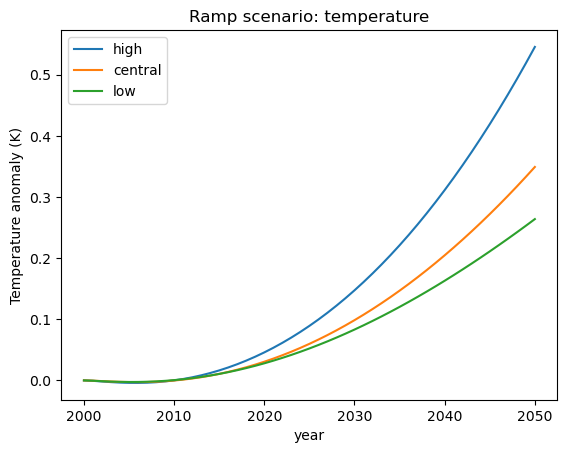

In [33]:
pl.plot(f.timebounds, f.temperature.loc[dict(scenario='ramp', layer=0)], label=f.configs)
pl.title('Ramp scenario: temperature')
pl.xlabel('year')
pl.ylabel('Temperature anomaly (K)')
pl.legend()

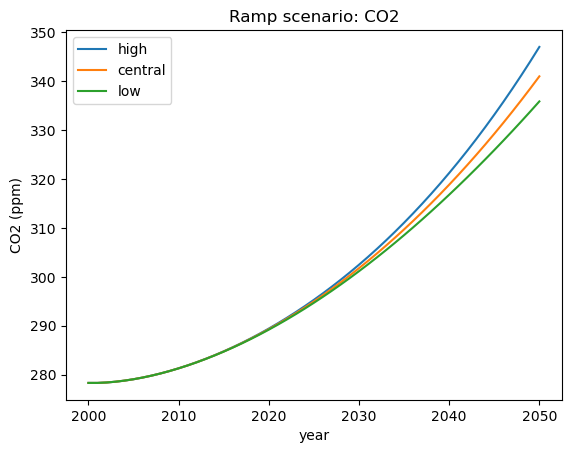

In [34]:
pl.plot(f.timebounds, f.concentration.loc[dict(scenario='ramp', specie='CO2')], label=f.configs)
pl.title('Ramp scenario: CO2')
pl.xlabel('year')
pl.ylabel('CO2 (ppm)')
pl.legend()

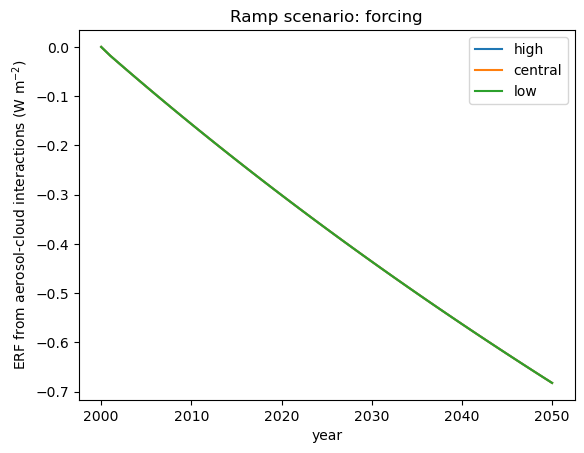

In [35]:
pl.plot(f.timebounds, f.forcing.loc[dict(scenario='ramp', specie='ERFaci')], label=f.configs)
pl.title('Ramp scenario: forcing')
pl.xlabel('year')
pl.ylabel('ERF from aerosol-cloud interactions (W m$^{-2}$)')
pl.legend()

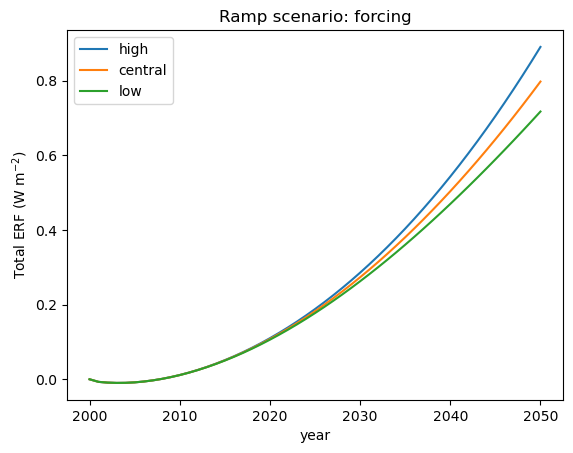

In [36]:
pl.plot(f.timebounds, f.forcing_sum.loc[dict(scenario='ramp')], label=f.configs)
pl.title('Ramp scenario: forcing')
pl.xlabel('year')
pl.ylabel('Total ERF (W m$^{-2}$)')
pl.legend()

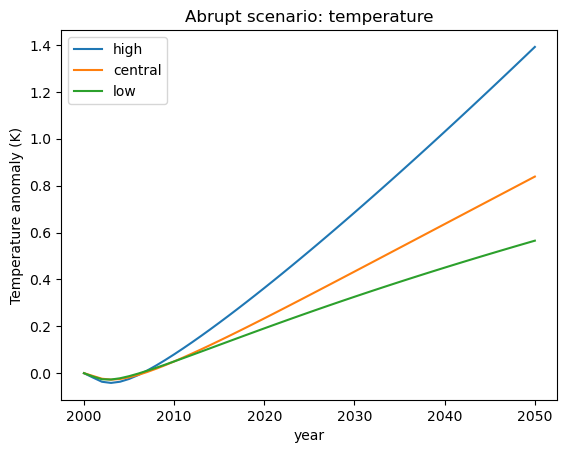

In [37]:
pl.plot(f.timebounds, f.temperature.loc[dict(scenario='abrupt', layer=0)], label=f.configs)
pl.title('Abrupt scenario: temperature')
pl.xlabel('year')
pl.ylabel('Temperature anomaly (K)')
pl.legend()

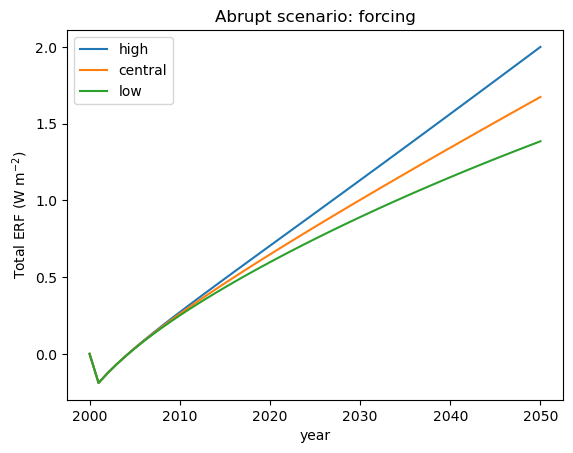

In [38]:
pl.plot(f.timebounds, f.forcing_sum.loc[dict(scenario='abrupt')], label=f.configs)
pl.title('Abrupt scenario: forcing')
pl.xlabel('year')
pl.ylabel('Total ERF (W m$^{-2}$)')
pl.legend()

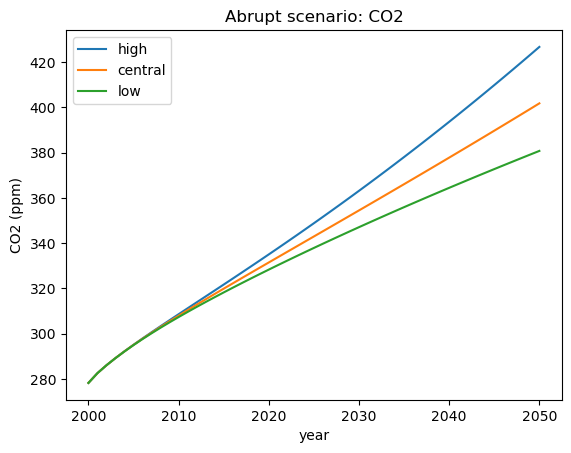

In [39]:
pl.plot(f.timebounds, f.concentration.loc[dict(scenario='abrupt', specie='CO2')], label=f.configs)
pl.title('Abrupt scenario: CO2')
pl.xlabel('year')
pl.ylabel('CO2 (ppm)')
pl.legend()

In [40]:
f.species_configs['g0'].loc[dict(specie='CO2')]

<xarray.DataArray 'g0' (config: 3)>
array([0.01017829, 0.01017829, 0.01017829])
Coordinates:
  * config   (config) <U7 'high' 'central' 'low'
    specie   <U20 'CO2'

In [41]:
f.forcing[-1, :, 1, :]

<xarray.DataArray (scenario: 2, specie: 8)>
array([[        nan,         nan,         nan,  0.60387977,  0.17318605,
         1.94527764, -0.36657357, -0.68209523],
       [        nan,         nan,         nan,  0.60387977,  0.17404145,
         1.06826241, -0.36657357, -0.68209523]])
Coordinates:
    timebounds  float64 2.05e+03
  * scenario    (scenario) <U6 'abrupt' 'ramp'
    config      <U7 'central'
  * specie      (specie) <U20 'CO2 fossil emissions' ... 'ERFaci'